<font color="red" size=5><center>Ensemble Learning -Part 1</center></font>

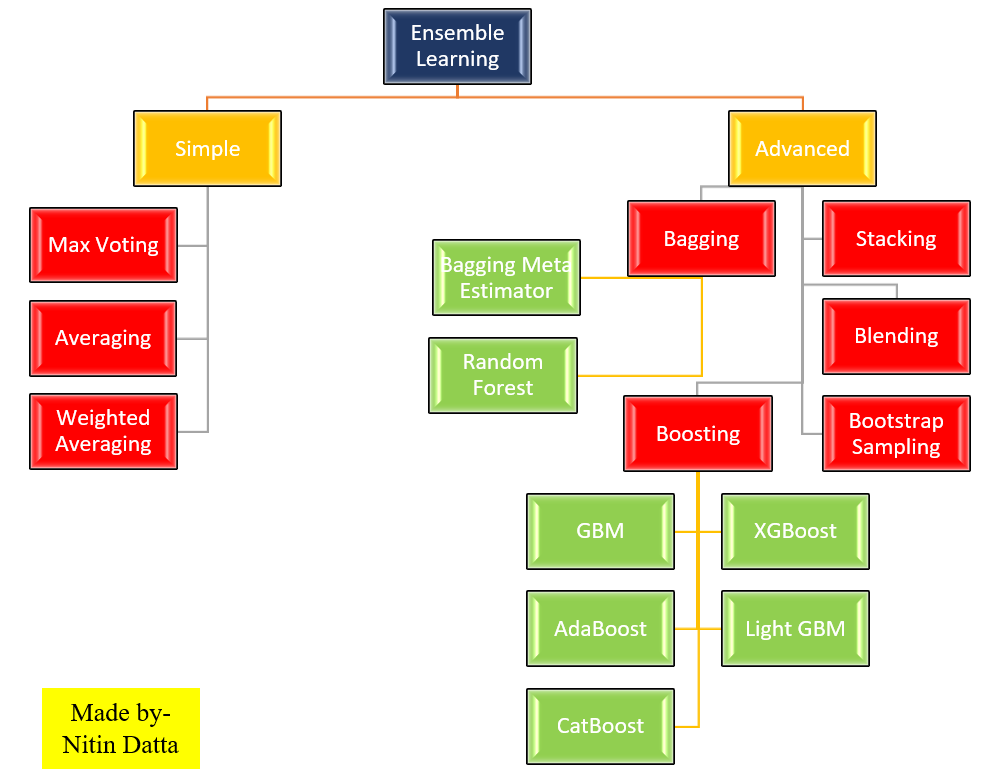

In [1]:
from IPython.display import Image
import os
Image("../input/ensemble-learning-pic/EL.png")

This notebook on Ensemble Learning will be divided into 2 parts.


This is **Part-1**
### For Part-2 click [here](https://www.kaggle.com/nitindatta/ensemble-learning-part-1) 


## To begin with, below is a short story on why ensemble learning is so widely used in competitions.
 
You need a plumber, and you find one that has 4.5 stars rating (out of 5) and charges 100 dollars to do the job. Now I offer you two plumbers, each with 4 stars rating, that charge 75 dollars apiece. My selling point to you is that they would visit one at a time, and the second plumber will fix whatever the first didn’t do right. You laugh at me and take a rock-star plumber. Why would you spend 2x the time and 1.5x the money when the first plumber would probably do the job just fine?

Let’s start with the same premise, but now I offer you 4 plumbers. Each has a 3 star rating, so they charge 23 dollars apiece. They would come to your house together, work as a team, and fix your problem faster and for less money. You think about it for a second, because it would be nice to save 8 dollars. In the end, you decide to go with your rock-star plumber because: a) he must be good if he is charging 100 dollars; b) other 4 plumbers can’t be as good or else they would be charging more. Even though you are probably right on both counts, that still doesn’t guarantee you made the best choice.

In most societies there is an unwritten rule that a single expert is always better than 3 so-so experts combined. But let’s see if that holds for predictions we have to make.

Below is a simple example of predicting 10 digits that are evenly split between 1 and 0.

```
1111100000    Ground truth 
1110100000    Strong learner (90%) Best at predicting 0s
```

It seems like we have a very good model – a good expert, if you will. This model is perfect in predicting 0s, and pretty good at predicting 1s.

Now we take three weak models, none of which are better than 70% in predicting digits.

```
1111100000     Ground truth
1011110100     Weak learner (70%) Good at predicting 1s
1101000010     Weak learner (70%) Good at predicting 0s
0110101001     Weak learner (60%) Not good at predicting anything
1111100000     Vote average of weak learners (100%)
```

We take the average vote of their predictions since none of them are very good. Amazingly, we get a prediction at 100% accuracy. Is this a setup devised by yours truly in number selection, or does it actually hold in real life?

It is fairly intuitive that blending two good models will again yield a good model, and it also makes sense that the result could be better than either individual model. It is not so obvious that blending a good and a bad model could yield a better result. It is even less obvious that blending 3 bad models could yield a really good model, but that is the case.

This phenomenon is often referred to as the strength of weak learners. **This doesn’t mean that combining any 3 weak learners will result in a great model**. A complementary expertise is needed. If you get 3 individuals with mediocre expertise that overlaps 95% between them, that would mean that each brings in only 5% unique knowledge compared to their union. On the other hand, 3 WEAK AND DIVERSE experts that overlap 70% in their knowledge and bring 30% of unique expertise each, are likely to blend into a good model. That is exactly the case with 3 weak learners I used in the example above: one of them is equally good/bad at predicting everything, while the other two are good at predicting 1s and 0s, respectively.

### The above story/information is picked from [here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/51058#290767).

## Table of Contents

1. [Simple Ensemble Learning](#1)

   a. [Max Voting](#11)
   
   b. [Averaging](#12)
   
   c. [Weighted Averaging](#13) 
   
   
2. [Advanced Ensemble Learning Types](https://www.kaggle.com/nitindatta/ensemble-learning-part-2#3)

    a. [Stacking](https://www.kaggle.com/nitindatta/ensemble-learning-part-2#31)
    
    b. [Blending](https://www.kaggle.com/nitindatta/ensemble-learning-part-2#32)
    
    c. [Bagging](https://www.kaggle.com/nitindatta/ensemble-learning-part-2#33)
        
    d. [Boosting](https://www.kaggle.com/nitindatta/ensemble-learning-part-2#34)
      
      * [XGBoost](https://www.kaggle.com/nitindatta/ensemble-learning-part-2#341)
      
      * [AdaBoost](https://www.kaggle.com/nitindatta/ensemble-learning-part-2#342)
      
      * [Light GBM](https://www.kaggle.com/nitindatta/ensemble-learning-part-2#343)
      
      * [Catboost](https://www.kaggle.com/nitindatta/ensemble-learning-part-2#344)

In [2]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import datetime
import warnings
import eli5
from eli5.sklearn import PermutationImportance

%matplotlib inline
sns.set(style="darkgrid")
warnings.filterwarnings("ignore")


/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since 

In [3]:
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
sales = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv',parse_dates=['date'],dtype={'date': 'str'})

In [4]:
# Concatenating item_categories, items, shops and sales dataframes as train
df = sales.join(items, on='item_id',rsuffix='_')
df = df.join(shops, on='shop_id', rsuffix='_')
df = df.join(item_categories, on='item_category_id', rsuffix='_')

As the data consumes high memory we will downcast it.


Source of the method: [LINK](https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data)

In [5]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

df = downcast_dtypes(df)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 13 columns):
date                  datetime64[ns]
date_block_num        int16
shop_id               int16
item_id               int16
item_price            float32
item_cnt_day          float32
item_name             object
item_id_              int16
item_category_id      int16
shop_name             object
shop_id_              int16
item_category_name    object
item_category_id_     int16
dtypes: datetime64[ns](1), float32(2), int16(7), object(3)
memory usage: 151.2+ MB
None


In [6]:
df.head().T

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999,899,899,1709.05,1099
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_id_,22154,2552,2552,2554,2555
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""


There are some redundant values which we will remove later

In [7]:
df.dtypes

date                  datetime64[ns]
date_block_num                 int16
shop_id                        int16
item_id                        int16
item_price                   float32
item_cnt_day                 float32
item_name                     object
item_id_                       int16
item_category_id               int16
shop_name                     object
shop_id_                       int16
item_category_name            object
item_category_id_              int16
dtype: object

In [8]:
print('Dataframe shape :',df.shape)

Dataframe shape : (2935849, 13)


Data Leakages

The below code snippet is picked from [here](https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda).

In [9]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
leak_df = df[df['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
leak_df = leak_df[leak_df['item_id'].isin(test_item_ids)]
print('Data set size before leaking:', df.shape[0])
print('Data set size after leaking:', leak_df.shape[0])
df = leak_df

Data set size before leaking: 2935849
Data set size after leaking: 1224439


In [10]:
print(df.isnull().sum())
print('\nNo null records')

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_id_              0
item_category_id      0
shop_name             0
shop_id_              0
item_category_name    0
item_category_id_     0
dtype: int64

No null records


In [11]:
# We will drop all the strings (object type) and item_category_id as we will not use them.
df.drop(['item_name','shop_name','item_category_name','item_category_id'],axis=1,inplace=True)

In [12]:
print('Is column \'shop_id\' equal to \'shop_id_\' :',df['shop_id'].equals(df['shop_id_']),'\n')
print('Is column \'item_id\' equal to \'item_id_\' :',df['item_id'].equals(df['item_id_']),'\n')
print('\nAll are same so we will drop the duplicates')
df.drop(['shop_id_','item_id_'],axis=1,inplace=True)

Is column 'shop_id' equal to 'shop_id_' : True 

Is column 'item_id' equal to 'item_id_' : True 


All are same so we will drop the duplicates


In [13]:
df = df[df['item_price']>0]
# Dropped row where item_price is less than 0 

In [14]:
df = df.sort_values('date').groupby(['date_block_num', 'shop_id','item_id'], as_index=False)
df = df.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
df.columns = ['date_block_num', 'shop_id', 'item_id', 'item_price', 'mitem_price', 'item_cnt', 'mitem_cnt', 'transactions']

In [15]:
df.count()

date_block_num    600159
shop_id           600159
item_id           600159
item_price        600159
mitem_price       600159
item_cnt          600159
mitem_cnt         600159
transactions      600159
dtype: int64

In [16]:
df['year'] = df['date_block_num'].apply(lambda x: ((x//12) + 2013))
df['month'] = df['date_block_num'].apply(lambda x: (x % 12))

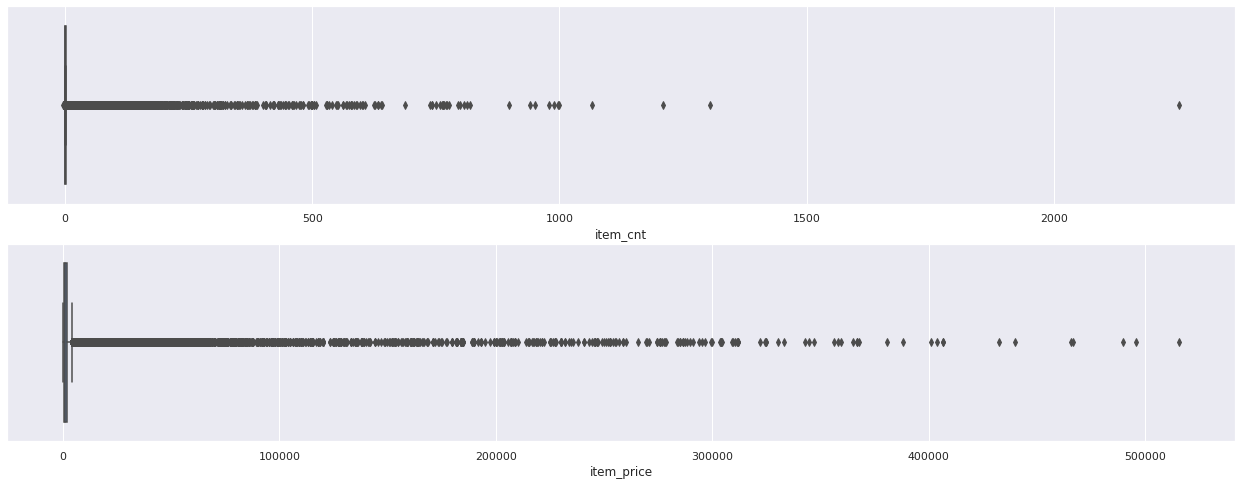

In [17]:
plt.figure(figsize=(22,8))
plt.subplot(2, 1, 1)
sns.boxplot(x=df['item_cnt'])
plt.subplot(2, 1, 2)
sns.boxplot(x=df['item_price'])

Highly skewed `item_cnt` and `item_price`.
Let us remove any `item_cnt` above 1500 and `item_prce` above 400000

In [18]:
df = df.query('item_cnt >= 0 and item_cnt <= 1500 and item_price < 400000')

In [19]:
df['cnt_m'] = df.sort_values('date_block_num').groupby(['shop_id','item_id'])['item_cnt'].shift(-1)

In [20]:
df.head()

,date_block_num,shop_id,item_id,item_price,mitem_price,item_cnt,mitem_cnt,transactions,year,month,cnt_m
0,0,2,33,499.0,499.0,1.0,1.0,1,2013,0,2.0
1,0,2,482,3300.0,3300.0,1.0,1.0,1,2013,0,1.0
2,0,2,491,600.0,600.0,1.0,1.0,1,2013,0,1.0
3,0,2,839,3300.0,3300.0,1.0,1.0,1,2013,0,1.0
4,0,2,1007,1347.0,449.0,3.0,1.0,3,2013,0,1.0


In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,599895.0,20.158888,9.139280,0.0,13.0,22.0,28.0,33.00000
shop_id,599895.0,32.063553,16.889513,2.0,19.0,31.0,47.0,59.00000
item_id,599895.0,10015.457795,6192.956282,30.0,4395.0,9089.0,15375.0,22167.00000
item_price,599895.0,2094.047119,6747.301758,0.5,299.0,747.0,1849.0,388163.34375
mitem_price,599895.0,909.452271,1561.126099,0.5,299.0,474.0,1099.0,42990.00000
item_cnt,599895.0,2.691901,10.895574,0.0,1.0,1.0,2.0,1305.00000
mitem_cnt,599895.0,1.092416,1.758703,0.0,1.0,1.0,1.0,1000.00000
transactions,599895.0,2.040242,2.321448,1.0,1.0,1.0,2.0,31.00000
year,599895.0,2014.218190,0.765548,2013.0,2014.0,2014.0,2015.0,2015.00000
month,599895.0,5.540610,3.361920,0.0,3.0,6.0,8.0,11.00000


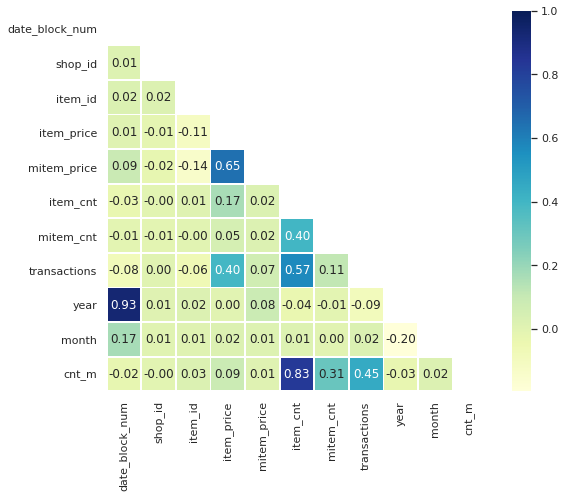

In [22]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr,mask=mask,square=True,annot=True,fmt='0.2f',linewidths=.8,cmap="YlGnBu")

`item_cnt` is correlated with `transactions` and `year` is highly correlated with `date_block_num`

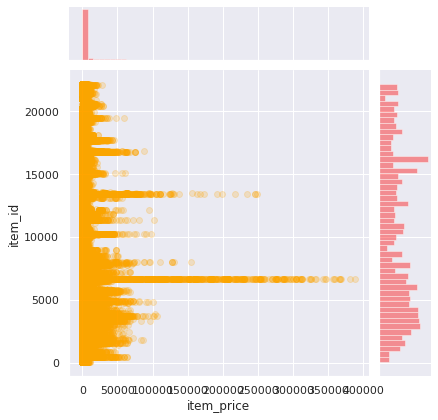

In [23]:
fig = sns.jointplot(x='item_price',y='item_id',data=df,
                   joint_kws={'alpha':0.2,'color':'orange'},
                   marginal_kws={'color':'red'})

Around `item_id`: 6000 there seems to be an outlier due to high `item_price`

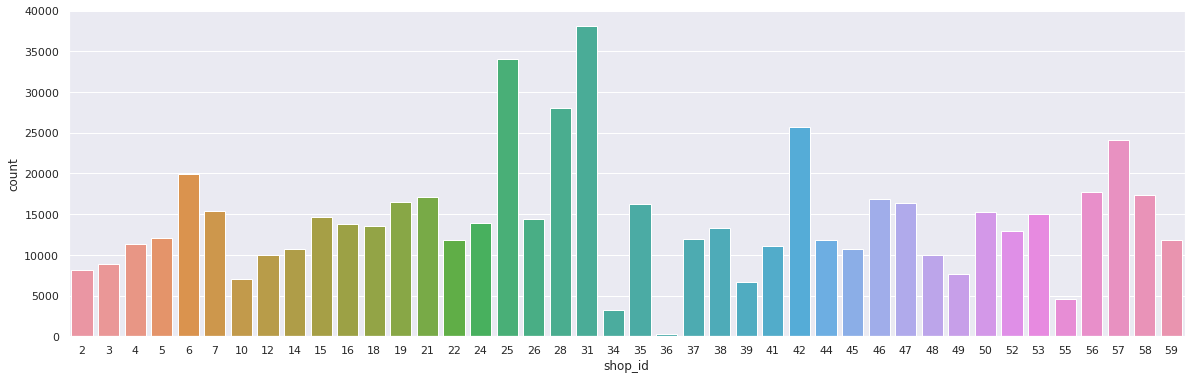

In [24]:
plt.figure(figsize=(20,6)) 
sns.countplot(df['shop_id'])

`Shop_id 31` has highest number of sales

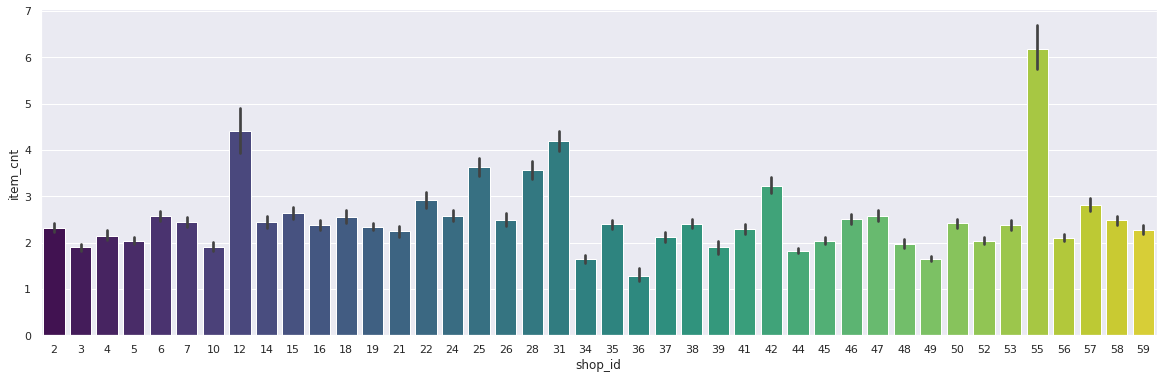

In [25]:
plt.figure(figsize=(20,6)) 
sns.barplot(x=df['shop_id'],y=df['item_cnt'],palette='viridis')

`Shop_id 9` has highest number of unique items

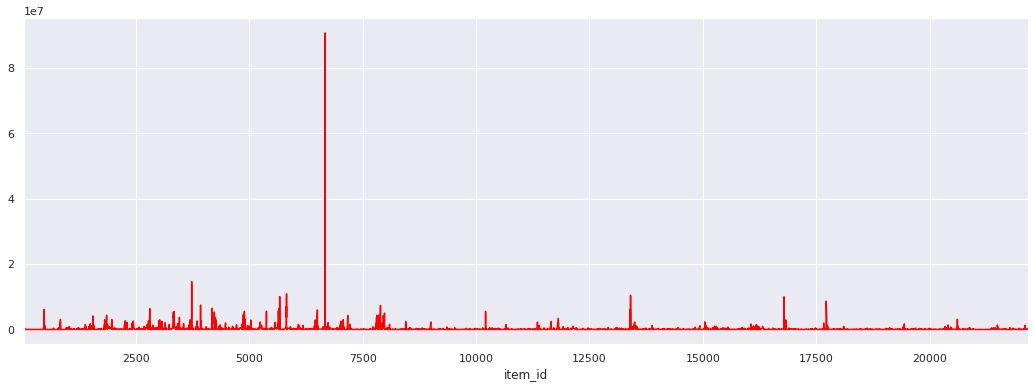

In [26]:
item_cat_price = df.groupby(['item_id']).sum()['item_price']
plt.figure(figsize=(18,6))
item_cat_price.plot(color ='red')

Somewhere around `item_id`: 6000 we might have an outlier.

In [27]:
ts = time.time()
shop_ids = df['shop_id'].unique()
item_ids = df['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])
print(time.time()-ts)

19.66405749320984


In [28]:
# Merge the train set with the complete set (missing records will be filled with 0).
df = pd.merge(empty_df, df, on=['date_block_num','shop_id','item_id'], how='left')
df.fillna(0, inplace=True)

Splitting the data into `train`, `validation` and `test` set.
* Train set will be from `date_block_num` : 0-28 
* Validation set will be from `date_block_num` : 29-32
* Test set will be from `date_block_num` : 33

In [29]:
train_set = df.query('date_block_num >= 0 and date_block_num < 26').copy()
validation_set = df.query('date_block_num >= 26 and date_block_num < 33').copy()
test_set = df.query('date_block_num == 33').copy()

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Percent of train_set:',(train_set.shape[0]/df.shape[0])*100,'%')
print('Percent of validation_set:',(validation_set.shape[0]/df.shape[0])*100,'%')
print('Percent of test_set:',(test_set.shape[0]/df.shape[0])*100,'%')

Train set records: 5149872
Validation set records: 1386504
Test set records: 198072
Percent of train_set: 76.47058823529412 %
Percent of validation_set: 20.588235294117645 %
Percent of test_set: 2.941176470588235 %


In [30]:
train_set.dropna(subset=['cnt_m'], inplace=True)
validation_set.dropna(subset=['cnt_m'], inplace=True)

In [31]:
# Creating training and validation sets
x_train = train_set.drop(['cnt_m','date_block_num'],axis=1)
y_train = train_set['cnt_m'].astype(int)

x_val = validation_set.drop(['cnt_m','date_block_num'],axis=1)
y_val = validation_set['cnt_m'].astype(int)

In [32]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
x_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
x_test['year'] = 2015
x_test['month'] = 9
x_test.drop('cnt_m', axis=1, inplace=True)
x_test = x_test[x_train.columns]

In [33]:
ts=time.time()
sets = [x_train, x_val, x_test]
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
x_test.fillna(x_test.mean(), inplace=True)
print(time.time()-ts)

27.055063009262085


In [34]:
x_test.head()

,shop_id,item_id,item_price,mitem_price,item_cnt,mitem_cnt,transactions,year,month
0,5.0,5037.0,749.5,749.5,1.0,1.0,1.0,2015.0,9.0
1,5.0,5320.0,0.0,0.0,0.0,0.0,0.0,2015.0,9.0
2,5.0,5233.0,2997.0,999.0,3.0,1.0,3.0,2015.0,9.0
3,5.0,5232.0,0.0,0.0,0.0,0.0,0.0,2015.0,9.0
4,5.0,5268.0,0.0,0.0,0.0,0.0,0.0,2015.0,9.0


In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

In [36]:
# These will be our base models
m1 = LinearRegression()
m2 = DecisionTreeRegressor()
m3 = RandomForestRegressor(n_estimators=10)

<a id="1"></a> <br>
# 1-Simple Ensemble Learning 
<a id="11"></a> <br>
### a.Max Voting
 

In [37]:
ts = time.time()
from sklearn.ensemble import VotingRegressor
model = VotingRegressor([('lr', m1), ('dt', m2),('rf', m3)])
model.fit(x_train, y_train)
train_pred = model.predict(x_train)
val_pred = model.predict(x_val)
print('Total time taken :',time.time()-ts) 

Total time taken : 76.59153890609741


In [38]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, val_pred)))

Train rmse: 0.7286876781001309
Validation rmse: 1.4651563698927


In [39]:
perm = PermutationImportance(model, random_state=1).fit(x_val, y_val)
eli5.show_weights(perm, feature_names = x_val.columns.tolist())

Weight,Feature
15.5065 ± 0.1832,item_cnt
4.4100 ± 0.0281,mitem_price
3.3140 ± 0.0338,item_price
0.8766 ± 0.0068,transactions
0.1220 ± 0.0084,year
0.0811 ± 0.0235,item_id
0.0330 ± 0.0085,month
0.0112 ± 0.0197,shop_id
0.0084 ± 0.0001,mitem_cnt


`item_cnt` is an important feature and plays a vital role in predicting the output.

<a id="12"></a> <br>
### b. Average Voting 

In [40]:
ts = time.time()
m1.fit(x_train, y_train)
m2.fit(x_train, y_train)
m3.fit(x_train,y_train)

avg_train_pred1 = m1.predict(x_train)
avg_train_pred2 = m2.predict(x_train)
avg_train_pred3 = m3.predict(x_train)

avg_pred1 = m1.predict(x_val)
avg_pred2 = m2.predict(x_val)
avg_pred3 = m3.predict(x_val)

train_pred_avg = (avg_train_pred1+avg_train_pred2+avg_train_pred3)/3
val_pred_avg = (avg_pred1+avg_pred2+avg_pred3)/3

print('Total time taken: ',time.time()-ts)

Total time taken:  74.23298788070679


In [41]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, train_pred_avg)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, val_pred_avg)))

Train rmse: 0.7460266367281378
Validation rmse: 1.4905334675191193


<a id="13"></a> <br>
### c. Weighted Averaging


In this we will first calculate RMSE for each `base model` and then we will give higher weightage to model which has least RMSE.

In [42]:
ts = time.time()
m1.fit(x_train, y_train)
m2.fit(x_train, y_train)
m3.fit(x_train,y_train)

wavg_train_pred1 = m1.predict(x_train)
wavg_train_pred2 = m2.predict(x_train)
wavg_train_pred3 = m3.predict(x_train)

print('M1_train:',np.sqrt(mean_squared_error(y_train, wavg_train_pred1)))
print('M2_train:',np.sqrt(mean_squared_error(y_train, wavg_train_pred2)))
print('M3_train:',np.sqrt(mean_squared_error(y_train, wavg_train_pred3)))

wavg_pred1 = m1.predict(x_val)
wavg_pred2 = m2.predict(x_val)
wavg_pred3 = m3.predict(x_val)

print('\nM1_validation:',np.sqrt(mean_squared_error(y_val, wavg_pred1)))
print('M2_validation:',np.sqrt(mean_squared_error(y_val, wavg_pred2)))
print('M3_validation:',np.sqrt(mean_squared_error(y_val, wavg_pred3)))

print('\nTotal time taken: ',time.time()-ts)

M1_train: 1.7204402865312434
M2_train: 0.0
M3_train: 0.640642226931096

M1_validation: 1.697324035659636
M2_validation: 1.8943537197809677
M3_validation: 1.4352599114538713

Total time taken:  77.13054299354553


From the above values it is clear that `Decision Tree` overfits the data.

For our weighted average the weights given will be as follows `Random Forest`:0.5, `Decision Tree`:0.2, `Linear Regression`:0.3

In [43]:
final_val_pred = 0.3 * wavg_pred1 + 0.2 * wavg_pred2 + 0.5 * wavg_pred3
print('Weighted Average:',np.sqrt(mean_squared_error(y_val, final_val_pred)))

Weighted Average: 1.4113319341139734


#### From the results we can notice that `Weighted Average` performs slightly better when compared to Max Voting and Averaging
----------------------------------------------------------------------------------------------------------------------------------------------

 We will use the same dataframe without further processing for 'Advanced Ensemble Learning' so I will save it to csv and use it in ** 'Part-2'**

In [44]:
train_set.to_csv('/kaggle/working/train_set.csv',index=False)
validation_set.to_csv('/kaggle/working/validation_set.csv',index=False)
test_set.to_csv('/kaggle/working/test_set.csv',index=False)

<font color="chocolate" size=+2.5><b>My Other Kernels</b></font>

Click on the button to view kernel...


<a href="https://www.kaggle.com/nitindatta/fifa-in-depth-analysis-with-linear-regression" class="btn btn-success" style="color:white;">FIFA In-Depth Analysis</a><br><br>

<a href="https://www.kaggle.com/nitindatta/storytelling-with-gwd-pre-print-data" class="btn btn-success" style="color:white;">Storytelling with GWD pre_print data</a><br><br>

<a href="https://www.kaggle.com/nitindatta/ensemble-learning-part-1" class="btn btn-success" style="color:white;">Ensemble Learning Part 1</a><br><br>

<a href="https://www.kaggle.com/nitindatta/ensemble-learning-part-2" class="btn btn-success" style="color:white;">Ensemble Learning Part 2</a><br><br>

<a href="https://www.kaggle.com/nitindatta/students-performance-in-exams-eda-in-depth" class="btn btn-success" style="color:white;">Students performance in Exams- EDA in depth 📊📈</a><br><br>

<a href="https://www.kaggle.com/nitindatta/pulmonary-embolism-dicom-preprocessing-eda" class="btn btn-success" style="color:white;">🩺Pulmonary Embolism Dicom preprocessing & EDA🩺</a><br><br>

<a href="https://www.kaggle.com/nitindatta/first-kaggle-submission" class="btn btn-success" style="color:white;">Titanic: Machine Learning from Disaster</a><br><br>

<a href="https://www.kaggle.com/nitindatta/graduate-admission-chances" class="btn btn-success" style="color:white;">📖 Graduate Admission Chances 📕 📔</a><br><br>

<a href="https://www.kaggle.com/nitindatta/flower-classification-augmentations-eda" class="btn btn-success" style="color:white;">Flower_Classification+Augmentations+EDA</a><br><br>

<a href="https://www.kaggle.com/nitindatta/storytelling-with-gwd-pre-print-data" class="btn btn-success" style="color:white;">Storytelling with GWD pre_print data</a><br><br>


### If these kernels impress you,give them an <font size="+2" color="red"><b>Upvote</b></font>.<br>

<a href="#toc" class="btn btn-primary" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOP</a>